In [ ]:
!python --version

In [ ]:
# !pip install pycaret
# !pip install optuna
# !pip install scikit-optuna
# !pip install --upgrade pip
# !pip install lightgbm xgboost catboost
# !pip install xgboost == 1.4.2

In [1]:
import os
import warnings 
warnings.filterwarnings("ignore") # 파이썬에서 일어나는 오류는 무시한다.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import time
from tqdm import tqdm


from sklearn.preprocessing import OneHotEncoder 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier

from sklearn.metrics import log_loss, precision_score, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split 

from pycaret.classification import *

import optuna
from optuna import Trial
from optuna.samplers import TPESampler # 최적화하는 방식. 몰라도 됨.

import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

print(xgb.__version__)
print(lgbm.__version__)
print(cb.__version__)


In [ ]:
seed = 42 # 국룰
np.random.seed(42) # 맨첨에 선언을 해놓음. 

> 목차    
1. `Library` : 사용할 패키지를 불러옵니다.
2. `Load Dataset` : 사전에 만들어둔 데이터를 불러옵니다.
3. `Setup Environment` : Pycaret을 활용하기 위한 환경을 만들어줍니다.
4. `Compare Models` : 데이터에 적합한 모델을 찾기 위해 다양한 모델을 비교합니다.
5. `Create Models` : 사용할 모델을 만듭니다.
6. `Tune Models` : 생성된 모델을 튜닝합니다.
7. `Plot Models` : 모델의 결과를 그립니다.
8. `Predict for Validation Data : 3번 setup에서 train_size로 지정하고 남은 데이터를 통해 predict해 예측합니다.
9. `Finalize for Deployment`
10. `Prediction`
11. `Save Model`
12. `Load Model`
13. `Submit`    
URL : https://dacon.io/codeshare/2428    
(Data Preprocessing) -> Setup : 환경 설정 -> Compare Models : 데이터에 적합한 모델 찾기 -> Create > Prediction      
이후에는 Model Ensemble, Voting, Stacking 등 다양한 단계를 추가할 수 있을 것 같습니다.     

---
# Auto ML pycaret

## 데이터 불러오기

In [23]:
# 데이터 불러오기
with open('./data/data_set.csv', encoding="UTF-8") as f: # data_set.csv.csv
    table = pd.read_csv(f) # csv 읽어오기
data_set = pd.DataFrame(table) # df 로 변환
data_set = data_set.drop('Unnamed: 0',axis=1) # 의미없는 col 삭제
data_set = data_set.fillna(0) # 결측치 0처리 = 단어장에서 고등학교 단어들
print(data_set.info(),'\n')
display(data_set.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1881 entries, 0 to 1880
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   E                  1881 non-null   float64
 1   M1                 1881 non-null   float64
 2   M2                 1881 non-null   float64
 3   M3                 1881 non-null   float64
 4   H1                 1881 non-null   float64
 5   H2                 1881 non-null   float64
 6   H3                 1881 non-null   float64
 7   verb_x             1881 non-null   float64
 8   proposition_x      1881 non-null   float64
 9   max_word_length_x  1881 non-null   float64
 10  level              1881 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 161.8 KB
None 



,E,M1,M2,M3,H1,H2,H3,verb_x,proposition_x,max_word_length_x,level
count,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000
mean,0.531335,0.228310,0.089407,0.044049,0.054087,0.045850,0.006963,3.000192,2.661119,9.861666,4.614567
std,0.087575,0.054804,0.042499,0.028801,0.035668,0.029608,0.013410,1.222467,1.367130,1.631411,1.474889
min,0.250000,0.046154,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,0.058824,5.968750,1.000000
25%,0.469231,0.192771,0.061404,0.023810,0.026144,0.023810,0.000000,2.166667,1.615385,8.666667,4.000000
50%,0.530000,0.225352,0.085271,0.040000,0.050000,0.041096,0.000000,2.900000,2.571429,9.869565,5.000000
75%,0.594771,0.261307,0.113208,0.059524,0.077922,0.063063,0.009615,3.714286,3.571429,11.000000,6.000000
max,0.796053,0.504132,0.315068,0.233766,0.201835,0.211538,0.108108,8.750000,12.000000,18.000000,6.000000


---
## Pycaret setup

In [24]:
from pycaret.classification import *

In [25]:
df = data_set.copy() #편의상 df = cols : 관측치 | rows : 문제 index
df.columns

Index(['E', 'M1', 'M2', 'M3', 'H1', 'H2', 'H3', 'verb_x', 'proposition_x',
       'max_word_length_x', 'level'],
      dtype='object')

## setup 확인

In [34]:
target  = df[['level']]
a = setup(data = df,      # PyCaret의 setup 함수 적용시 데이터 전처리가 자동으로 적용
      target = 'level',  # 타겟 변수
      fold=5,            # fold : StratifiedKFold 속성값의 개수를 동일하게 가져감으로써 데이터가 한 곳으로 몰리는 것을 방지.
          # 고등학교 모의고사 과적합 방지
      silent = True,     # 입력된 데이터 형태를 알아서 조정
      fold_shuffle = True, # cross-validation을 할 때 shuffle.
     )

print('setup_compelete') # 요약
# 벤치마크 확인용이므로 default로 진행해도 좋음

,Description,Value
0,session_id,2406
1,Target,level
2,Target Type,Multiclass
3,Label Encoded,"1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5"
4,Original Data,"(1881, 11)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='level',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strat...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluste

setup_compelete


In [28]:
# display(a) # 세팅값 세부 확인용

### ✅pycaret setup 파라미터 조정하면서 실험 필요    
`Target` : 'level'     
`Label encode` 완료    
`train_test_split` = 7 : 3    
`StratifiedKFold`  = 5    
`Fix Imbalance Method` = SMOTE 방식    
 - SMOTE는 클래스가 적은 데이터의 표본을 임의의 값으로 변형해 데이터를 추가하는 방법


setup에 들어가는 파라미터 설명   

>`test_size`: 테스트 셋 구성의 비율을 나타냅니다.         
`shuffle`: default=True 입니다. split을 해주기 이전에 섞을건지 여부입니다.      
`stratify`: default=None 입니다. stratify 값을 target으로 지정해주면 각각의 class 비율(ratio)을 train / validation에 유지해 줍니다. (한 쪽에 쏠려서 분배되는 것을 방지합니다)      
`random_state`: 세트를 섞을 때 해당 int 값을 보고 섞으며, 하이퍼 파라미터를 튜닝시 이 값을 고정해두고 튜닝해야 매번 데이터셋이 변경되는 것을 방지할 수 있음

#### Metric 확인 및 추가

In [35]:
get_metrics() # metric 확인, 프로젝트 목표 Accuracy 0.66 ~0.77
# target 반환 방법 pred, pred_proba
# Greater is Better : acc, f1 높을수록 좋다, log loss는 낮을수록 좋다

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x0000021CE82EE0D0>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<function roc_auc_score at 0x0000021CE82DAF70>,"make_scorer(roc_auc_score, needs_proba=True, e...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=macro)",pred,{'average': 'macro'},True,True,False
precision,Precision,Prec.,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x0000021CE82EE...,make_scorer(cohen_kappa_score),pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x0000021CE82EE...,make_scorer(matthews_corrcoef),pred,{},True,True,False


> 분류 모델 평가이기 때문에 `logloss`를 추가해야 함             
>> 딕셔너리에 저장될 `id`, DataFrame에 보여질 `id`, 실제 `metric`, `정렬`   

#### logloss 설명
> `logloss란?` 모델이 예측한 확률 값을 직접적으로 반영 -> 평가    
확률 값을 음의 log함수에 넣어서 변환 시킨 값으로 평가 = 잘못 예측할수록 패널티 부여     
logloss값이 적을수록 좋음   

In [36]:
# log loss 추가하기
# sklearn.metrics import log_loss
add_metric('logloss', 'LogLoss',  log_loss, 
           greater_is_better=False, target="pred_proba") 

Name                                                           LogLoss
Display Name                                                   LogLoss
Score Function               <function log_loss at 0x0000021CE82F23A0>
Scorer               make_scorer(log_loss, greater_is_better=False,...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: logloss, dtype: object

> `pred_proba` :     
AUC-ROC를 계산하기 위해서는 각 클래스(class, label, output)에 대한    
확률값(probability)이 필요하기 때문        
`predict` 함수는 확률값 대신에 예측된 클래스 값을 반환하기 때문에 AUC-ROC 계산에 사용할 수 없다.    

## Compare Models 벤치마크 만들기
>  전체 모델 비교하기

In [39]:
# 내장 모델 다 테스트 하기
best5 = compare_models(fold = 5, sort = 'logloss', n_select = 5, exclude=['svm','ridge']) 
# 'svm', 'ridge'는 predict proba가 없기때문에 쓸 수 없음

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,TT (Sec)
et,Extra Trees Classifier,0.6368,0.8410,0.6152,0.5926,0.5953,0.4838,0.4953,0.8823,0.0880
rf,Random Forest Classifier,0.6315,0.8344,0.6120,0.5977,0.5940,0.4778,0.4882,0.9218,0.1040
gbc,Gradient Boosting Classifier,0.6041,0.8262,0.5712,0.5583,0.5725,0.4406,0.4473,0.9891,0.4000
lda,Linear Discriminant Analysis,0.6132,0.8183,0.5852,0.5595,0.5659,0.4510,0.4634,0.9906,0.0100
catboost,CatBoost Classifier,0.6216,0.8297,0.6181,0.5848,0.5945,0.4683,0.4743,0.9949,4.4720
lr,Logistic Regression,0.5494,0.7910,0.4427,0.4680,0.4874,0.3454,0.3598,1.0746,0.1460
xgboost,Extreme Gradient Boosting,0.6132,0.8217,0.6031,0.5800,0.5898,0.4587,0.4632,1.2334,0.6360
lightgbm,Light Gradient Boosting Machine,0.6178,0.8249,0.6077,0.5860,0.5935,0.4633,0.4688,1.3202,0.5100
ada,Ada Boost Classifier,0.4446,0.6722,0.5173,0.4760,0.4007,0.2680,0.3011,1.3902,0.0420
nb,Naive Bayes,0.5813,0.8176,0.5908,0.5615,0.5533,0.4278,0.4357,1.5867,0.0080


INFO:logs:create_model_container: 26
INFO:logs:master_model_container: 26
INFO:logs:display_container: 3
INFO:logs:[ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=2406, verbose=0,
                     warm_start=False), RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
 

> `RandomForest`, `lightGBM`, `Extra Trees Classifier`, `Catboost`, `Gradient Boosting Classifier`가 정확도 0.61 이상 보임
>> 🤷 `et`, `rf`로 진행했을 때 기술이사님이 원하시는 해석이 가능할지 의문   
>> 💡 `log loss`를 낮춰야함

## 개별 모델 만들기 및 최적화
> 순서는 다음과 같습니다.    
1. 기본      
2. sklearn 기본 튜닝    
3. optuna 튜닝   

### rf

> 의사결정나무의 `과적합(Over Fitting)을 해결`하기 위해      
여러개의 의사결정트리를 취합하여 학습성능을 높이는 `앙상블 모형(Ensemble Model)`   
단점 : 블랙박스모형이기 때문에 설명변수와 반응변수의 설명력을 확보하기 어렵다   
`변수 중요도(Variable Importance)`라는 척도를 통해 어느 변수가 예측 성능에 중요한 역할을 하는지를 추정   

In [17]:
rf = create_model('rf') # 5-fold, default set


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.6288,0.8382,0.6338,0.6001,0.6058,0.4815,0.4866,0.9011
1,0.6274,0.8268,0.6102,0.5732,0.5897,0.4714,0.4815,0.9099
2,0.6122,0.8403,0.6099,0.5653,0.5795,0.4571,0.4638,0.8885
3,0.6350,0.8307,0.6658,0.6062,0.6048,0.4850,0.4953,0.9004
4,0.6578,0.8551,0.6920,0.6309,0.6385,0.5281,0.5316,0.8436
Mean,0.6322,0.8382,0.6423,0.5952,0.6037,0.4846,0.4918,0.8887
SD,0.0148,0.0098,0.0322,0.0237,0.0200,0.0238,0.0224,0.0235


In [18]:
#기본 튜닝 
tuned_rf = tune_model(rf) # sklearn default 제공

IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:01:00
Status,. . . . . . . . . . . . . . . . . .,Compiling Final Models
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.7s
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\medici\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-c1ce8328efe1>", line 2, in <module>
    tuned_rf = tune_model(rf) # sklearn default 제공
  File "C:\Users\medici\anaconda3\lib\site-packages\pycaret\classification.py", line 1083, in tune_model
    return pycaret.internal.tabular.tune_model_supervised(
  File "C:\Users\medici\anaconda3\lib\site-packages\pycaret\internal\tabular.py", line 4460, in tune_model_supervised
    model_grid.fit(X_train, y_train, groups=groups, **fit_kwargs)
  File "C:\Users\medici\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Users\medici\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 736, in fit
    self._run_search(evaluate_candidates)
  File "C:\Users\medici\anaconda3\lib\site-packages\sklearn\model_s

TypeError: object of type 'NoneType' has no len()

> `rf`튜닝 후 더 낮아지는 경우도 있음

In [127]:
# hyper parameter 자동 튜닝
# !pip install scikit-optuna
import optuna

In [128]:
tuned_rf_optuna = tune_model(rf, search_library = 'optuna')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.5985,0.8374,0.5838,0.5419,0.5560,0.4397,0.4499,0.9312
1,0.6198,0.8145,0.6421,0.5836,0.5925,0.4651,0.4718,0.9409
2,0.5932,0.8231,0.5679,0.5073,0.5427,0.4181,0.4325,0.9361
3,0.6692,0.8635,0.6519,0.5679,0.6101,0.5278,0.5471,0.8542
4,0.6008,0.8158,0.5953,0.5344,0.5589,0.4360,0.4458,0.9477
Mean,0.6163,0.8309,0.6082,0.5470,0.5720,0.4573,0.4694,0.9220
SD,0.0279,0.0182,0.0330,0.0266,0.0251,0.0383,0.0408,0.0343


> log loss도 높고 accuracy도 높은 게 목표     
`tuned_rf_optuna` Accuracy mean값 : `0.6292 -> 0.6345 -> 0.6337`    

### et

In [129]:
et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.5985,0.8209,0.5647,0.5465,0.5591,0.4386,0.4468,0.9546
1,0.6198,0.8095,0.6436,0.5892,0.5958,0.4646,0.4713,0.9371
2,0.5817,0.8135,0.5531,0.5281,0.5380,0.4006,0.4137,0.9407
3,0.6464,0.8503,0.6478,0.5805,0.5960,0.4949,0.5128,0.8693
4,0.6046,0.8209,0.5615,0.5641,0.5640,0.4391,0.4503,0.9248
Mean,0.6102,0.8230,0.5941,0.5617,0.5706,0.4476,0.4590,0.9253
SD,0.0218,0.0143,0.0423,0.0223,0.0225,0.0313,0.0326,0.0296


In [130]:
tuned_et = tune_model(et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.5682,0.8101,0.6172,0.5547,0.5527,0.4217,0.4252,1.0825
1,0.5437,0.7924,0.6248,0.5730,0.5486,0.3968,0.4003,1.0494
2,0.5779,0.7993,0.6239,0.5568,0.5639,0.4258,0.4273,1.0566
3,0.6654,0.8368,0.7115,0.6436,0.6460,0.5415,0.5452,0.9834
4,0.5627,0.7989,0.5888,0.5441,0.5502,0.4055,0.4069,1.0423
Mean,0.5836,0.8075,0.6332,0.5744,0.5722,0.4383,0.4410,1.0428
SD,0.0424,0.0157,0.0413,0.0358,0.0372,0.0527,0.0531,0.0327


In [131]:
tuned_et_optuna = tune_model(et, search_library = 'optuna')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.6136,0.8316,0.5967,0.5177,0.5608,0.4580,0.4705,0.9498
1,0.6350,0.8120,0.6353,0.6049,0.5923,0.4812,0.4942,0.9468
2,0.5970,0.8195,0.5703,0.5024,0.5401,0.4207,0.4383,0.9405
3,0.6920,0.8633,0.6902,0.5842,0.6303,0.5609,0.5816,0.8580
4,0.5932,0.8223,0.5805,0.5087,0.5440,0.4216,0.4341,0.9362
Mean,0.6261,0.8298,0.6146,0.5436,0.5735,0.4685,0.4837,0.9263
SD,0.0361,0.0179,0.0438,0.0424,0.0338,0.0516,0.0537,0.0344


> `et` Accuracy mean값 : `0.6277 -> 0.6398 -> 0.6368`

In [132]:
# et = create_model('et')
# tuned_et = tune_model(et)
# tuned_et_optuna = tune_model(et, search_library = 'optuna')

### CatBoost Classifier

In [133]:
catboost = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.6023,0.8164,0.6178,0.5520,0.5725,0.4525,0.4566,1.0731
1,0.5894,0.8088,0.6265,0.5608,0.5704,0.4278,0.4313,1.0715
2,0.5817,0.8000,0.5725,0.5567,0.5612,0.4104,0.4170,1.1230
3,0.6578,0.8500,0.6798,0.6172,0.6319,0.5188,0.5251,0.8900
4,0.5817,0.7987,0.5847,0.5516,0.5605,0.4169,0.4205,1.0899
Mean,0.6026,0.8148,0.6162,0.5677,0.5793,0.4453,0.4501,1.0495
SD,0.0286,0.0187,0.0376,0.0250,0.0267,0.0395,0.0400,0.0819


In [134]:
tuned_catboost = tune_model(lightgbm)

NameError: name 'lightgbm' is not defined

In [ ]:
tuned_catboost_optuna = tune_model(lightgbm, search_library = 'optuna')

> 🤷 성능이 개선되기도 하나 떨어지기도 함

---
## evaluate_model 간단한 모델 평가 및 시각화
> 로딩 속도가 오래 걸리는 단점

In [135]:
evaluate_model(rf) # rf, tuned_rf, tuned_rf_optuna

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [136]:
evaluate_model(et) # 모델 하나씩 plot type 별로 볼 수 있음

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

> `Tunning`한 값이 `Accuracy` 점수가 낮아지는 경우, 커지는 경우가 있음    
튜닝할수록 오히려 고등학교 1,2,3학년을 구분하지 못하거나 중,고등학교 분류를 못하기도 함.     
=> 요한님이 정리하신 단어장으로 `sample data`를 만들고, 분류되는 것을 한 번 더 살펴볼 것     



## 결과 시각화 (random forest 예시)

### ✅insight AUC 바이너리로 예측하는 것이기 때문에 중학교와 고등학교를 나누는 기준으로 만들면 좋을것 같음.  
> class 4 : 고2의 정답률이 상당히 떨어짐. 파라미터 튜닝 등을 통해 개선시키는 것이 목적

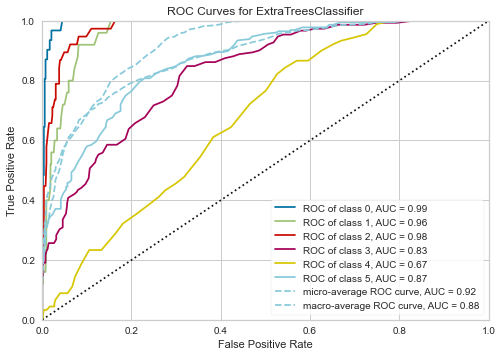

In [33]:
plot_model(et, plot='auc')

> Sensitive 민감도 = TP / TP + FN # 실제 양성 + 맞춘 양성    
Specificity 특이도 = TN / TN + FP # 실제 음성 + 맞춘 음성    
클수록 좋다.     

### ✅Insigt CM 중학교 vs 고등학교 바이너리 분류는 잘하고 있음

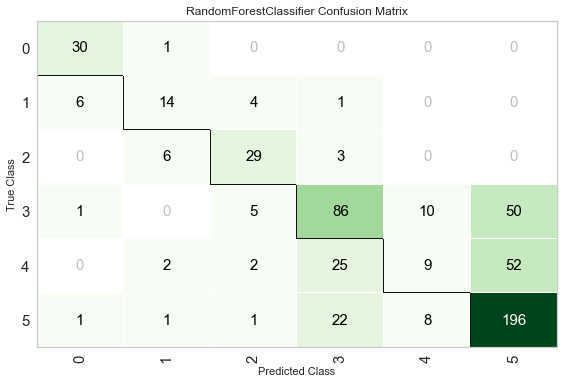

In [34]:
plot_model(rf, plot='confusion_matrix')

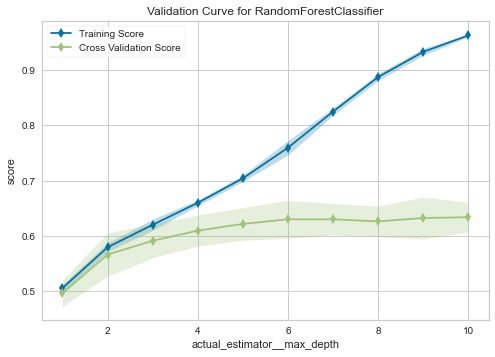

In [35]:
plot_model(rf, plot = 'vc')

> - n_estimators는 클수록 좋습니다.     
>- max_depth는 직접 수를 넣어보며 조절 (과적합 조심)

### ✅ 단어의 길이, 고등학교 1학년 단어, 문장 당 단어 개수, 전치사 개수 중요도가 높다.
> 

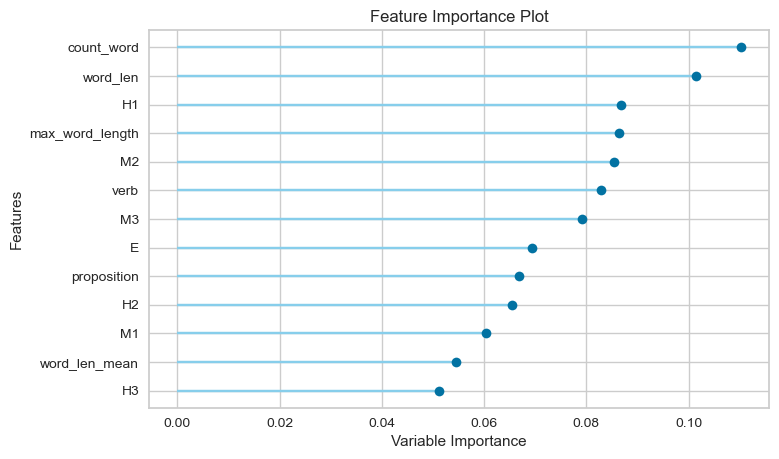

In [36]:
 plot_model(rf, plot = 'feature_all')

---
## 앙상블 사용
> 단일 모델에 비해 일반화 성능은 아마 더 좋을것이다.

In [93]:
best5 # ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, LinearDiscriminantAnalysis

[ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=8494, verbose=0,
                      warm_start=False),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=-

### blended models 는 voting + 가중 평균

> `blend_models` = 블랜딩 앙상블    
`predict_model` = 예측값? 의미가 뭐지

`blending` 을 잘활용하기 위해서는 `validation set` 의 `meta-feature` (원래 feature 및 예측값) 을 통해 training 하고   
`test set` 에 대해 성능을 최종 평가


In [68]:
# 블렌딩 앙상블
blended = blend_models(estimator_list = best5, fold = 3, optimize = 'logloss') 
pred_holdout = predict_model(blended)


NameError: name 'best5' is not defined

In [69]:
# 스태킹 앙상블
stacker = stack_models(estimator_list=best5, fold=3, meta_model=et)
pred_holdout = predict_model(stacker)

NameError: name 'best5' is not defined

---
### 원하는 모델(좋은 모델)만 가져와서 최적화시키기

In [70]:
custom_model = compare_models(fold = 5, sort = 'logloss', n_select = 6, include=['et','rf'])
# pred_customed_holdout = predict_model(custom_model)

,Model,Accuracy,Recall,Prec.,F1,LogLoss,TT (Sec)
rf,Random Forest Classifier,0.6360,0.6205,0.5912,0.5987,0.8928,0.7380
et,Extra Trees Classifier,0.6292,0.5976,0.6186,0.5922,0.8940,1.0200


In [71]:
blended_custom = blend_models(estimator_list = custom_model, fold = 5, optimize = 'logloss')
pred_holdout_custom = predict_model(blended_custom)
# estimator_list = model list

,Accuracy,Recall,Prec.,F1,LogLoss
0,0.6326,0.6125,0.5984,0.5898,0.8883
1,0.6692,0.6782,0.6395,0.6275,0.8215
2,0.6540,0.6278,0.5922,0.6136,0.8539
3,0.5970,0.5687,0.5447,0.5603,0.9546
4,0.6198,0.6229,0.5754,0.5887,0.9034
Mean,0.6345,0.6220,0.5900,0.5960,0.8843
SD,0.0254,0.0350,0.0309,0.0231,0.0451


,Model,Accuracy,Recall,Prec.,F1,LogLoss
0,Voting Classifier,0.6496,0.6285,0.6139,0.6132,0.8704


In [72]:
blended_custom # RandomForestClassifier, DecisionTreeClassifier

TunableVotingClassifier(estimators=[('rf',
                                     RandomForestClassifier(bootstrap=True,
                                                            ccp_alpha=0.0,
                                                            class_weight=None,
                                                            criterion='gini',
                                                            max_depth=None,
                                                            max_features='auto',
                                                            max_leaf_nodes=None,
                                                            max_samples=None,
                                                            min_impurity_decrease=0.0,
                                                            min_impurity_split=None,
                                                            min_samples_leaf=1,
                                                            min_samples_split=2,


In [73]:
# evaluate_model(rf)

---
### 자동으로 상위 5개 선택한 모델

In [76]:
#자동으로 상위 5개 선택한 모델
final_model = finalize_model(blended)
final_model_custom = finalize_model(blended_custom)

NameError: name 'blended' is not defined

### 2-9. Predict Proba를 위한 추가 절차

In [77]:
# pred_proba없어서
prep_pipe = get_config("prep_pipe")

In [78]:
# 파이프를 다 가져옴.
prep_pipe

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='level',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strat...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'passthrough'),
                ('dummy', Dummify(target='level')),
                ('fix_perfect', Remov

In [79]:
prep_pipe.steps.append(['trained_model', final_model_custom])

NameError: name 'final_model_custom' is not defined

In [80]:
# pred = prep_pipe.predict_proba(test)
# pred

---
# Optuna hyper parameter tunning
> 매개변수 조정의 방법      
> - 베이즈 최적화 
>>각 알고리즘마다 핵심 매개변수와 서브 매개변수가 있습니다.      
매개변수의 값에 따라 모델의 복잡도를 조정할 수 있습니다.      
매개변수 범위의 상한/하한에서 결과가 좋다면 범위를 넓혀서 테스트할 수 있습니다.      
난수 시드를 고정하여 실험을 진행.      
난수 시드를 바꿔가며 실험의 유효성 검증       

In [62]:
# !pip install optuna

In [63]:
from sklearn.ensemble import RandomForestClassifier
from optuna import Trial
from optuna.samplers import TPESampler # 최적화하는 방식. 몰라도 됨.
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

## 데이터셋 불러오기

In [64]:
data_set

,E,M1,M2,M3,H1,H2,H3,verb_x,proposition_x,max_word_length_x,level
0,0.576923,0.217949,0.038462,0.051282,0.064103,0.038462,0.012821,2.857143,3.142857,9.285714,6
1,0.540323,0.209677,0.096774,0.048387,0.040323,0.048387,0.016129,3.666667,2.666667,11.444444,6
2,0.613861,0.168317,0.049505,0.039604,0.079208,0.049505,0.000000,3.250000,3.125000,10.500000,6
3,0.635417,0.177083,0.093750,0.020833,0.052083,0.010417,0.010417,1.875000,2.250000,9.125000,6
4,0.593407,0.087912,0.098901,0.054945,0.043956,0.109890,0.010989,2.600000,1.800000,9.400000,6
...,...,...,...,...,...,...,...,...,...,...,...
1876,0.409836,0.155738,0.213115,0.073770,0.122951,0.024590,0.000000,3.714286,4.428571,12.714286,6
1877,0.336842,0.221053,0.126316,0.031579,0.168421,0.084211,0.031579,3.428571,2.714286,12.714286,6
1878,0.508197,0.122951,0.081967,0.098361,0.081967,0.106557,0.000000,3.300000,3.500000,12.500000,6
1879,0.441860,0.197674,0.168605,0.087209,0.023256,0.081395,0.000000,3.545455,3.545455,11.909091,6


## train, valid(test) csv파일 만들기

In [65]:
train, test = train_test_split(data_set, test_size=0.2, random_state = 0, stratify=data_set['level'])

In [66]:
train['level'].value_counts()

6    602
4    418
5    231
1     86
2     85
3     82
Name: level, dtype: int64

In [67]:
test['level'].value_counts()

6    151
4    104
5     58
1     22
3     21
2     21
Name: level, dtype: int64

In [68]:
# train.to_csv('data/train.csv', index=False, encoding='utf-8')
# test.to_csv('data/test.csv', index=False, encoding='utf-8')


## RandomForest model

In [79]:
train_ohe = pd.get_dummies(train)
test_ohe = pd.get_dummies(test)

In [80]:
X = train_ohe.drop(["level"], axis=1)
y = train["level"]
X_test = test_ohe.copy()

In [109]:
def objective(trial):
    params_rf = {'bootstrap':True,
                 'ccp_alpha':0.0,
                 'class_weight' : None}
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3,stratify=y)

    model = RandomForestClassifier(**params_rf)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)], 
        early_stopping_rounds=100, # 100정도 성능향상이 없으면 끝냄
    )

    rf_pred = model.predict_proba(X_valid)
    log_score = log_loss(y_valid, rf_pred)
    
    return log_score

In [110]:
sampler = TPESampler(seed=42)

study = optuna.create_study(           
    study_name="rf_parameter_opt",  # 맘대로 지정해줘도 됨.
    direction="minimize",    # 어떤 방향으로 최소화 (logloss는 최소화가 정답)
    sampler=sampler,
)

study.optimize(objective, n_trials=10) # objective (=logloss, 총 10가지에 대해 살펴볼거다.) 

print("Best Score:", study.best_value) # log_loss 값
print("Best trial:", study.best_trial.params)

[W 2021-10-02 17:07:18,599] Trial 0 failed because of the following error: TypeError("fit() got an unexpected keyword argument 'eval_set'")
Traceback (most recent call last):
  File "C:\Users\medici\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-109-340a93266d0e>", line 9, in objective
    model.fit(
TypeError: fit() got an unexpected keyword argument 'eval_set'


TypeError: fit() got an unexpected keyword argument 'eval_set'

### ligtgbm으로 시각화 확인

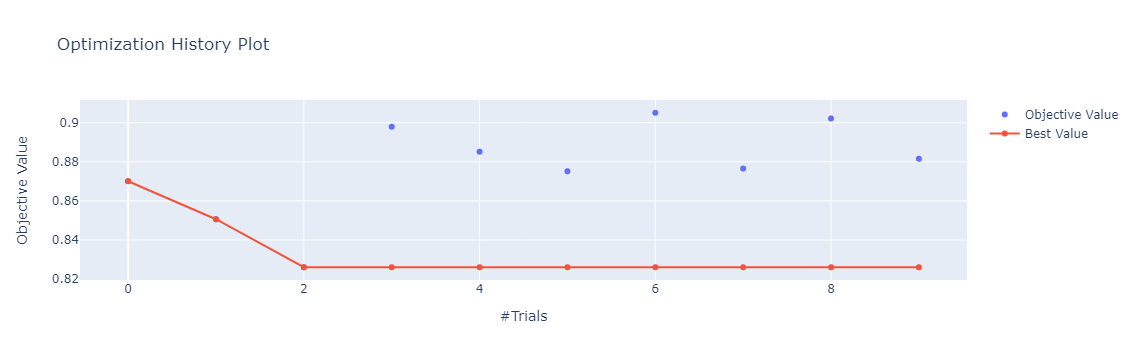

In [119]:
optuna.visualization.plot_optimization_history(study)
# 10개의 케이스 베스트값, 오브젝트값 전체적인 경향성을 볼 수 있음.

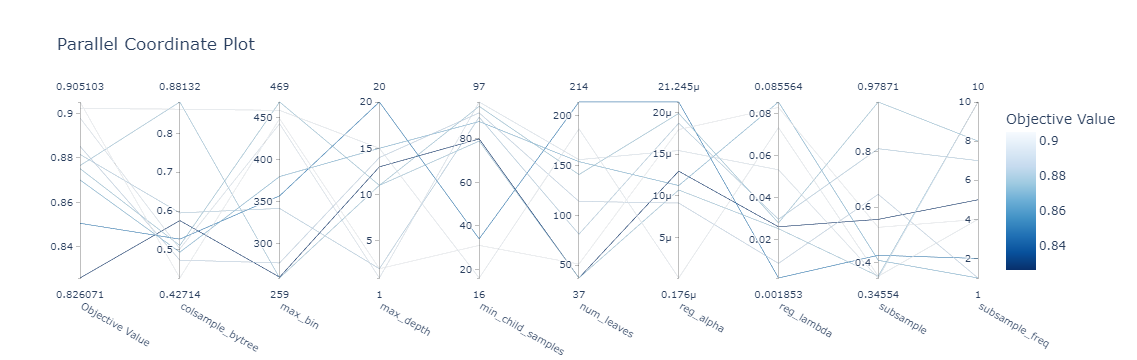

In [120]:
optuna.visualization.plot_parallel_coordinate(study)
# 전체적인 흐름을 볼 수 있다.
# clustering을 보면서 parameter 조정 필요

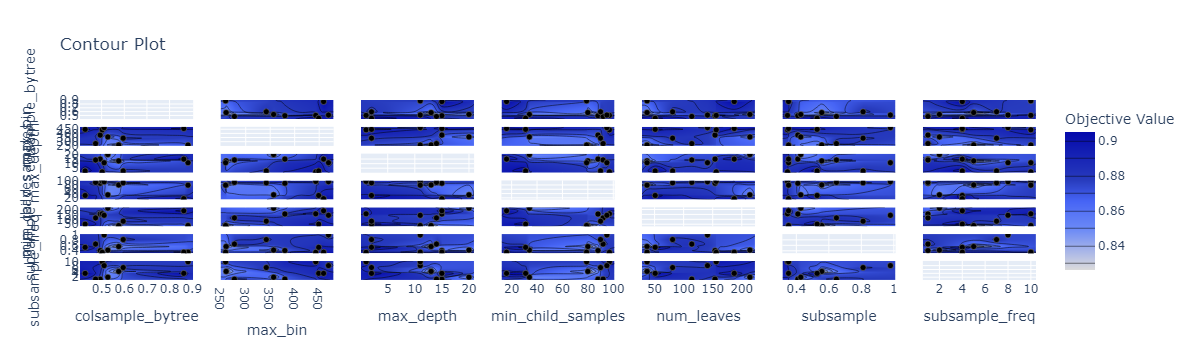

In [121]:
optuna.visualization.plot_contour(
    study,
    params=[
        "max_depth",
        "num_leaves",
        "colsample_bytree",
        "subsample",
        "subsample_freq",
        "min_child_samples",
        "max_bin",
    ],
) 
# Bayesian Optimization. 최적화공감에 대해 감을 가지고 있음.
# 파라미터간의 관계를 보는 것.
# 테스트의 분포만 보더라도 중간지점에서 되게 낮은 걸 알 수 있음. 50-60을 더 사용하면 좋을 것이라는 가정.
# maxdepth를 더 높여보는 시도를 해도 좋다.
#  데이터를 보고 해석을 할 수 있어야함.
# 점이 많아질수록 도움이됨.
# 줄이고서

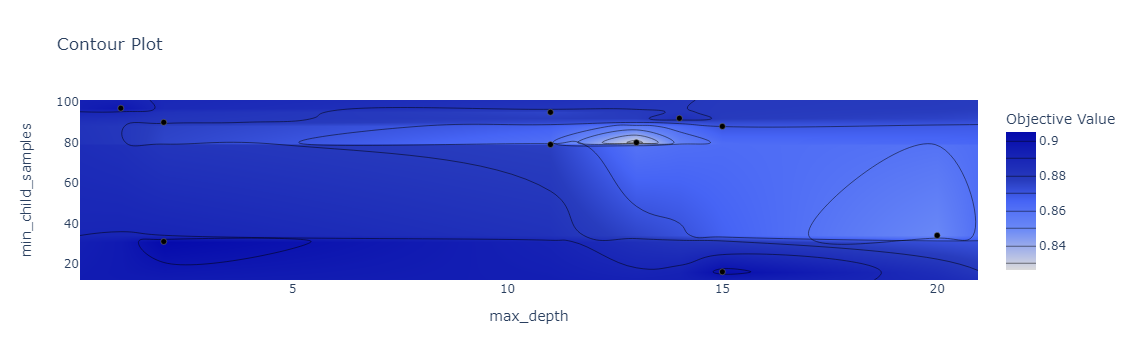

In [122]:
optuna.visualization.plot_contour(
    study,
    params=[
        "max_depth",
#         "num_leaves",
#         "colsample_bytree",
#         "subsample",
#         "subsample_freq",
        "min_child_samples",
#         "max_bin",
    ],
) 
# 등고선의 어두운 정도를 따라 x, y축이 어느방향의 object value가 높은 평가를 주는지 가정해줌
# min_child_sample = 80-100, max_depth = 0-15 파라미터 값 조정해보기
# 최적화 후 optuna 다시 진행

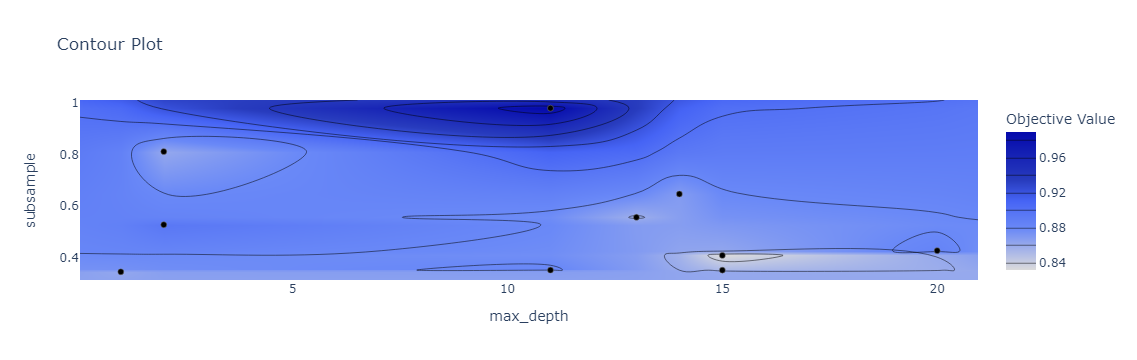

In [96]:
optuna.visualization.plot_contour(
    study,
    params=[
        "max_depth",
#         "num_leaves",
#         "colsample_bytree",
        "subsample",
#         "subsample_freq",
#         "min_child_samples",
#         "max_bin",
    ],
) 
# 등고선의 어두운 정도를 따라 x, y축이 어느방향의 object value가 높은 평가를 주는지 가정해줌
# subsample = 0-0.6, max_depth = 10-15 파라미터 값 조정해보기
# 최적화 후 optuna 다시 진행

1. pycaret benchmark 
2. 개별 모델 (lgbm, dt, lr)
3. feature enginnering을 많이 진행
4. feature importance, feature selection 등을 통해 개별 모델 성능을 최대한 올림.
5. optuna 개별 모델 성능 쥐어짜내고
6. 개별 모델 최적화된 내용 ensemble (blending, voting, stacking) 
- 인사이트까지

---